# Evaluate outcome models

## Define models to evaluate

In [19]:
import outcome_models
import importlib

In [70]:
importlib.reload(outcome_models)

<module 'outcome_models' from '/Users/lovhag/Projects/yelp_causal_inference/outcome_models.py'>

In [71]:
models = {"baseline_model": outcome_models.get_baseline_model(), 
        "linear_model": outcome_models.get_linear_model(), 
        "logistic_regression_model": outcome_models.get_logistic_regression_model(),
        "random_forest_model_1": outcome_models.get_random_forest_model_1(),
        "random_forest_model_2": outcome_models.get_random_forest_model_2(),
        "random_forest_model_3": outcome_models.get_random_forest_model_3(),
        "random_forest_model_4": outcome_models.get_random_forest_model_4()}

## Load evaluation data

In [3]:
import pandas as pd
from result_help_functions import Data

In [73]:
def get_pandas_data(filename):
    df = pd.read_csv(filename)
    df = df.dropna(axis=0)
    df.reset_index(inplace=True, drop=True)
    
    print("Data loaded! Loaded data info:")
    df.info()
    return df

In [74]:
def get_evaluation_data(filename, treatments, confounders):
    df = get_pandas_data(filename)

    return Data(df, treatments, confounders)

In [36]:
df = pd.read_csv('saved_data/data_features_interpretable.csv')
df = df.dropna(axis=0)
df.reset_index(inplace=True, drop=True)
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10114 entries, 0 to 10113
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                10114 non-null  object 
 1   business_id            10114 non-null  object 
 2   stars                  10114 non-null  int64  
 3   useful                 10114 non-null  int64  
 4   text                   10114 non-null  object 
 5   date                   10114 non-null  object 
 6   text_length            10114 non-null  int64  
 7   nbr_words              10114 non-null  int64  
 8   lemmatized_text        10114 non-null  object 
 9   processed_text         10114 non-null  object 
 10  test                   10114 non-null  int64  
 11  Z1                     10114 non-null  int64  
 12  Z2                     10114 non-null  int64  
 13  Z3                     10114 non-null  int64  
 14  is_positive_sentiment  10114 non-null  float64
 15  se

,user_id,business_id,stars,useful,text,date,text_length,nbr_words,lemmatized_text,processed_text,test,Z1,Z2,Z3,is_positive_sentiment,sentiment_certainty,n_words,n_fans,n_reviews,useful_discrete
0,6PgdGb3HrZdsfl2GiULo8w,RESDUcs7fIiihp38-d6_6g,5,0,After getting food poisoning at the Palms hote...,2012-12-04 03:10:18,937,176,get food poisoning Palms hotel scared eat buff...,After getting food poisoning at the Palms hote...,1,0,0,0,1.0,0.999428,176,0,3,0
1,IS9yw8P2uAPBX6FNLLX4KA,RESDUcs7fIiihp38-d6_6g,4,39,"""A feast worthy of Gods""\n\nBaccarnal Buffet i...",2014-01-17 00:50:50,4975,940,feast worthy god Baccarnal Buffet Caesar Palac...,"""A feast worthy of Gods"" Baccarnal Buffet in ...",1,1,0,1,0.0,0.990075,940,330,1224,1
2,uZdFsE_aHbFBChgN6Xa8tw,RESDUcs7fIiihp38-d6_6g,4,1,The crab legs are better than the ones at Wick...,2015-06-08 18:03:09,671,131,crab leg well one Wicked Spoon huge prawn shee...,The crab legs are better than the ones at Wick...,1,0,0,0,1.0,0.935575,131,113,1864,1
3,8ZWJNAEWsymXDzKx3B0tTQ,RESDUcs7fIiihp38-d6_6g,1,0,Not worth it! Too salty food and expensive! Th...,2016-12-19 16:15:29,92,18,worth salty food expensive furst kast visit bu...,Not worth it! Too salty food and expensive! Th...,0,0,1,0,0.0,0.999454,18,0,6,0
4,E0sm4Ve7ifanFYeQMcV8Eg,RESDUcs7fIiihp38-d6_6g,5,0,I would give this infinite stars if I could. M...,2015-07-28 07:13:17,333,63,infinite star family diamond card Caesars Pala...,I would give this infinite stars if I could. M...,1,0,1,0,1.0,0.999430,63,0,15,0


### Count number of samples per treatment group

In [40]:
df.groupby(treatments).user_id.count()

Z1  Z2  Z3
0   0   0     3011
        1      200
    1   0     4890
        1      411
1   0   0      531
        1      222
    1   0      746
        1      103
Name: user_id, dtype: int64

## Evaluate!

In [77]:
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import numpy as np

In [57]:
def get_treatment_model_crossval_scores(models, treatment_groups, X_data, Y_data):
    score_dict = {}

    for treatment in treatment_groups:
        score_dict[treatment] = get_treatment_model_crossval_scores_basic(models, X_data[treatment], Y_data[treatment])
    return score_dict

In [58]:
def get_treatment_model_crossval_scores_basic(models, X_data, Y_data):
    score_dict = {}

    for model_name, model in models.items():
        try: 
            score_dict[model_name] = cross_val_score(model, X_data, Y_data, cv=5)
        except Exception as e:
            print(f"Model evaluation failed for model: {model_name}")
            print("Caught exception: ")
            print(e)
    return score_dict

In [50]:
def get_mean_score_per_model(score_dict):
    mean_score = {}
    for treatment, model_scores in score_dict.items():
        for model_name, model_score in model_scores.items():
            if model_name in mean_score:
                mean_score[model_name] = (mean_score[model_name]+np.mean(model_score))/2
            else:
                mean_score[model_name] = np.mean(model_score)
    return mean_score

In [66]:
def plot_treatment_model_scores(score_dict):
    for treatment, model_scores in score_dict.items():
        plot_model_scores(model_scores, treatment)

In [83]:
def plot_model_scores(model_scores, plot_title):
    try:
        plt.figure(figsize=(15,5))
        plt.boxplot(x=model_scores.values(), labels=model_scores.keys())
        plt.title(plot_title)
        plt.show()
    except Exception as e:
        print(f"Score plot failed for plot title: {plot_title}")
        print("Caught exception: ")
        print(e)

### For discrete y

Data loaded! Loaded data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10114 entries, 0 to 10113
Data columns (total 25 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                10114 non-null  object 
 1   business_id            10114 non-null  object 
 2   stars                  10114 non-null  int64  
 3   useful                 10114 non-null  int64  
 4   text                   10114 non-null  object 
 5   date                   10114 non-null  object 
 6   text_length            10114 non-null  int64  
 7   nbr_words              10114 non-null  int64  
 8   lemmatized_text        10114 non-null  object 
 9   processed_text         10114 non-null  object 
 10  test                   10114 non-null  int64  
 11  Z1                     10114 non-null  int64  
 12  Z2                     10114 non-null  int64  
 13  buffet                 10114 non-null  int64  
 14  $                      

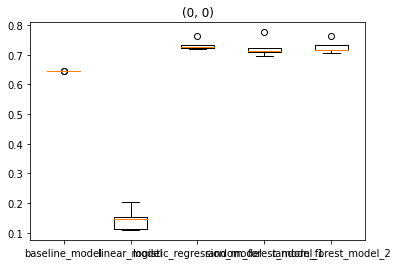

Score plot failed for plot title: (0, 1)
Caught exception: 
Dimensions of labels and X must be compatible


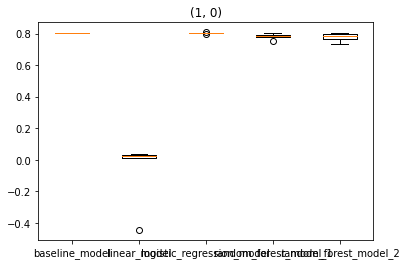

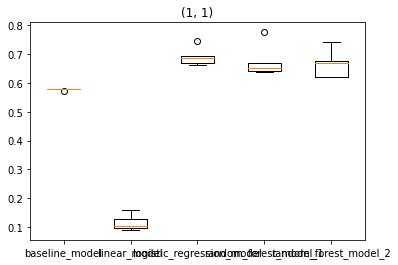

In [68]:
data = get_evaluation_data("saved_data/data_features_lovisa.csv", treatments = ['Z1', 'Z2'], confounders = ['is_positive_sentiment', 'n_words', 'n_fans', 'n_reviews'])
print("")
score_dict = get_treatment_model_crossval_scores(models, data.treatment_groups, data.X_test, data.Y_test_discrete)
print("")
print("MEAN MODEL SCORE:")
print(get_mean_score_per_model(score_dict))
plot_treatment_model_scores(score_dict)

Data loaded! Loaded data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10114 entries, 0 to 10113
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                10114 non-null  object 
 1   business_id            10114 non-null  object 
 2   stars                  10114 non-null  int64  
 3   useful                 10114 non-null  int64  
 4   text                   10114 non-null  object 
 5   date                   10114 non-null  object 
 6   text_length            10114 non-null  int64  
 7   nbr_words              10114 non-null  int64  
 8   lemmatized_text        10114 non-null  object 
 9   processed_text         10114 non-null  object 
 10  test                   10114 non-null  int64  
 11  Z1                     10114 non-null  int64  
 12  Z2                     10114 non-null  int64  
 13  Z3                     10114 non-null  int64  
 14  is_positive_sentiment  

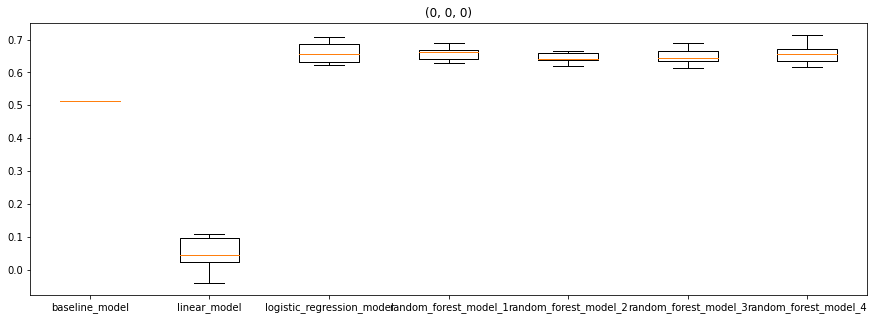

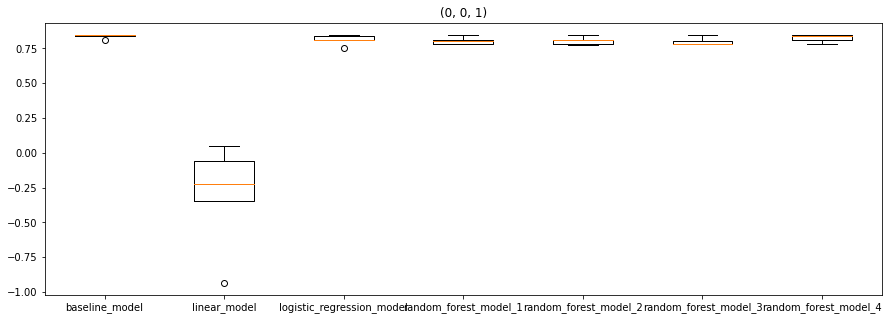

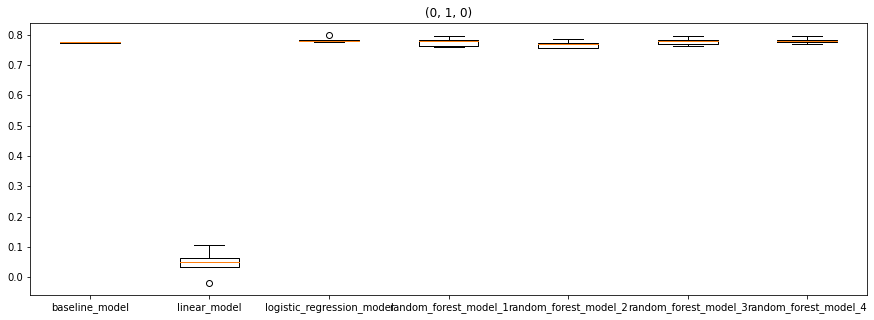

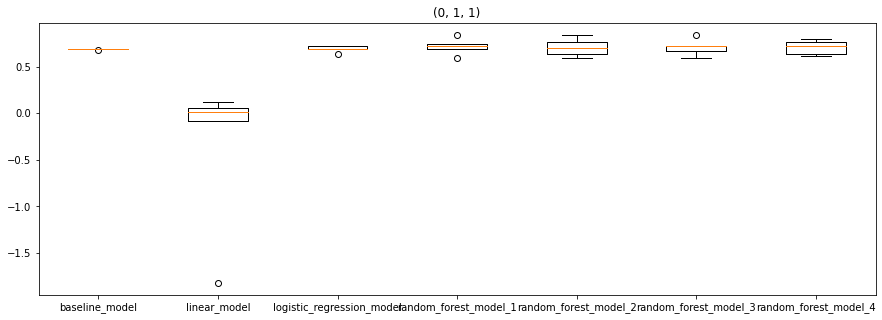

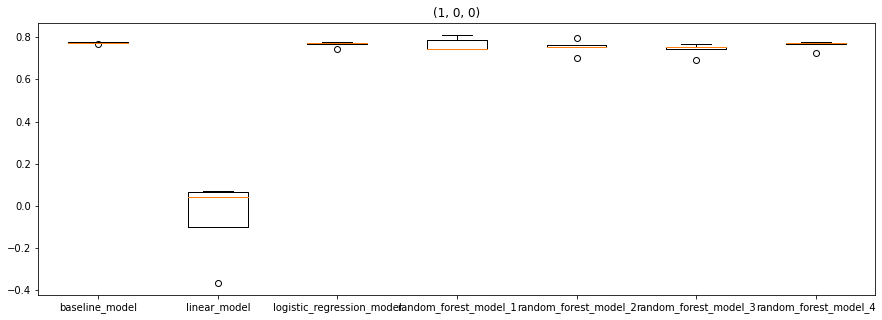

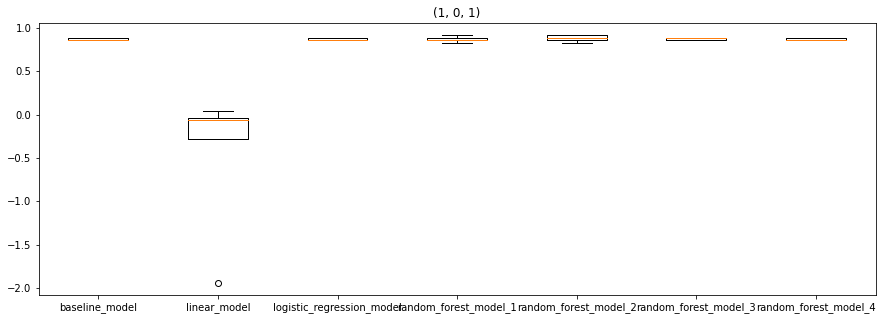

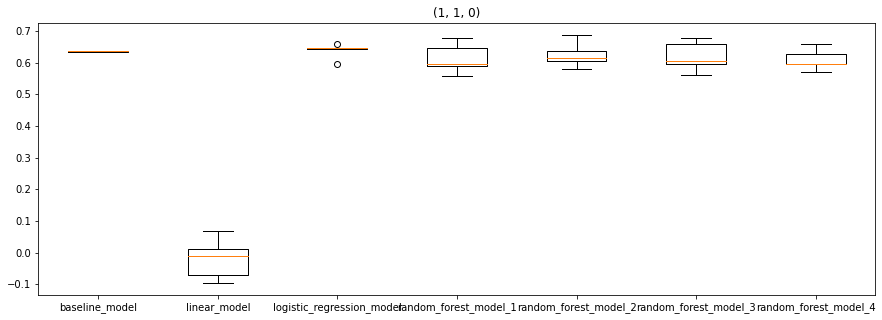

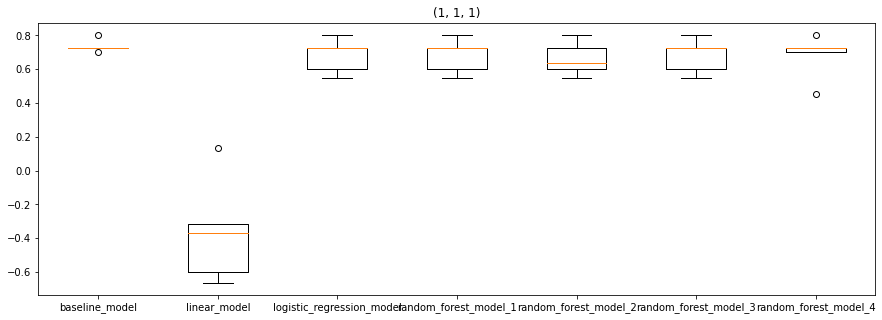

In [86]:
data = get_evaluation_data("saved_data/data_features_interpretable.csv", treatments = ['Z1', 'Z2', 'Z3'], confounders = ['is_positive_sentiment', 'n_words', 'n_fans', 'n_reviews'])
print("")
score_dict = get_treatment_model_crossval_scores(models, data.treatment_groups, data.X_test, data.Y_test_discrete)
print("")
print("MEAN MODEL SCORE:")
print(get_mean_score_per_model(score_dict))
plot_treatment_model_scores(score_dict)

### No scaling of data

Data loaded! Loaded data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10114 entries, 0 to 10113
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                10114 non-null  object 
 1   business_id            10114 non-null  object 
 2   stars                  10114 non-null  int64  
 3   useful                 10114 non-null  int64  
 4   text                   10114 non-null  object 
 5   date                   10114 non-null  object 
 6   text_length            10114 non-null  int64  
 7   nbr_words              10114 non-null  int64  
 8   lemmatized_text        10114 non-null  object 
 9   processed_text         10114 non-null  object 
 10  test                   10114 non-null  int64  
 11  Z1                     10114 non-null  int64  
 12  Z2                     10114 non-null  int64  
 13  Z3                     10114 non-null  int64  
 14  is_positive_sentiment  

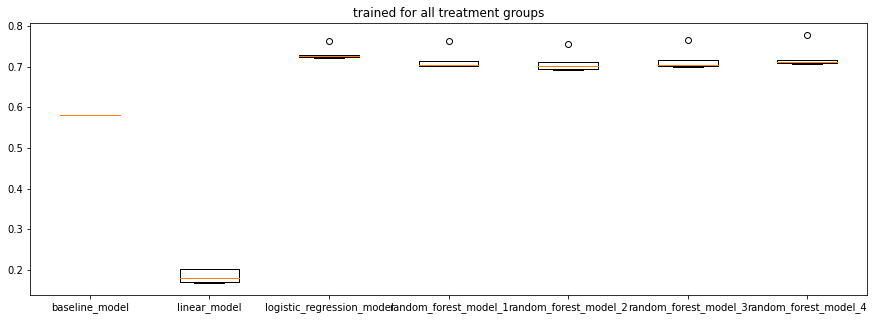

In [85]:
confounders = ['Z1','Z2', 'Z3', 'is_positive_sentiment', 'n_words', 'n_fans', 'n_reviews']
df = get_pandas_data('saved_data/data_features_interpretable.csv')
score_dict = get_treatment_model_crossval_scores_basic(models, df[df.test==1][confounders].to_numpy(), df[df.test==1].useful_discrete)
plot_model_scores(score_dict, "trained for all treatment groups")

### Scale data

Data loaded! Loaded data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10114 entries, 0 to 10113
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                10114 non-null  object 
 1   business_id            10114 non-null  object 
 2   stars                  10114 non-null  int64  
 3   useful                 10114 non-null  int64  
 4   text                   10114 non-null  object 
 5   date                   10114 non-null  object 
 6   text_length            10114 non-null  int64  
 7   nbr_words              10114 non-null  int64  
 8   lemmatized_text        10114 non-null  object 
 9   processed_text         10114 non-null  object 
 10  test                   10114 non-null  int64  
 11  Z1                     10114 non-null  int64  
 12  Z2                     10114 non-null  int64  
 13  Z3                     10114 non-null  int64  
 14  is_positive_sentiment  

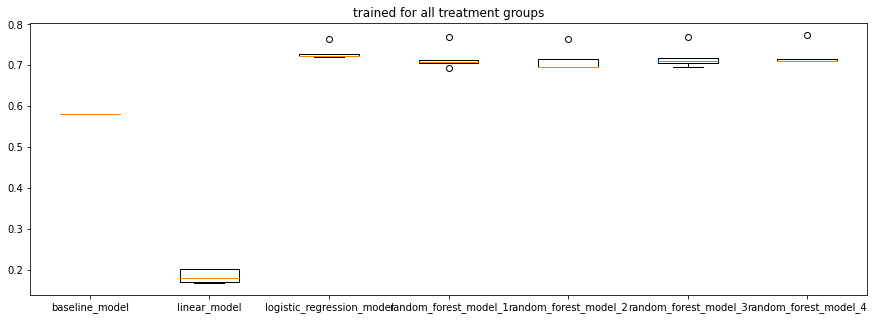

In [84]:
confounders = ['Z1','Z2', 'Z3', 'is_positive_sentiment', 'n_words', 'n_fans', 'n_reviews']
df = get_pandas_data('saved_data/data_features_interpretable.csv')
X_data = df[df.test==1][confounders].to_numpy()
scaler = StandardScaler()
scaler.fit(X_data)
X_data = scaler.transform(X_data)
Y_data = df[df.test==1].useful_discrete
score_dict = get_treatment_model_crossval_scores_basic(models, X_data, Y_data)
plot_model_scores(score_dict, "trained for all treatment groups")

### For continuous y

Model evaluation failed for treatment: (0, 1)
Caught exception: 
Expected sequence or array-like, got <class 'NoneType'>
Model evaluation failed for treatment: (0, 1)
Caught exception: 
Expected sequence or array-like, got <class 'NoneType'>
Model evaluation failed for treatment: (0, 1)
Caught exception: 
Expected sequence or array-like, got <class 'NoneType'>
Model evaluation failed for treatment: (0, 1)
Caught exception: 
Expected sequence or array-like, got <class 'NoneType'>
Model evaluation failed for treatment: (0, 1)
Caught exception: 
Expected sequence or array-like, got <class 'NoneType'>


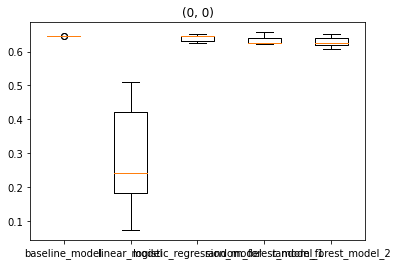

Score plot failed for treatment: (0, 1)
Caught exception: 
Dimensions of labels and X must be compatible


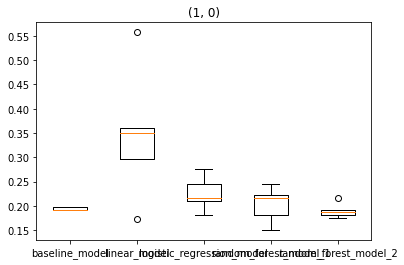

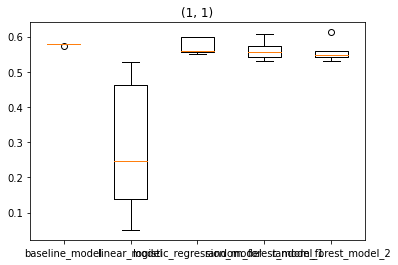

In [35]:
score_dict = get_treatment_model_crossval_scores(models, data.treatment_groups, data.X_test, data.Y_test)
plot_treatment_model_scores(score_dict)

Data loaded! Loaded data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10114 entries, 0 to 10113
Data columns (total 20 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   user_id                10114 non-null  object 
 1   business_id            10114 non-null  object 
 2   stars                  10114 non-null  int64  
 3   useful                 10114 non-null  int64  
 4   text                   10114 non-null  object 
 5   date                   10114 non-null  object 
 6   text_length            10114 non-null  int64  
 7   nbr_words              10114 non-null  int64  
 8   lemmatized_text        10114 non-null  object 
 9   processed_text         10114 non-null  object 
 10  test                   10114 non-null  int64  
 11  Z1                     10114 non-null  int64  
 12  Z2                     10114 non-null  int64  
 13  Z3                     10114 non-null  int64  
 14  is_positive_sentiment  

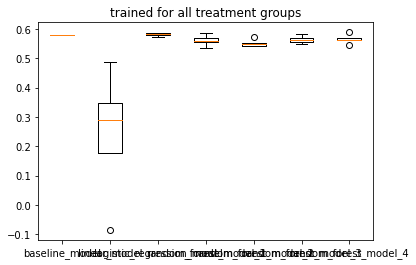

In [76]:
confounders = ['Z1','Z2', 'Z3', 'is_positive_sentiment', 'n_words', 'n_fans', 'n_reviews']
df = get_pandas_data('saved_data/data_features_interpretable.csv')
score_dict = get_treatment_model_crossval_scores_basic(models, df[df.test==1][confounders].to_numpy(), df[df.test==1].useful)
plot_model_scores(score_dict, "trained for all treatment groups")

##